In [ ]:
# Install required packages (Colab)
!pip install -q sentence-transformers openpyxl scipy

import io
import pandas as pd
from collections import Counter, defaultdict
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from google.colab import files


this code is doing generalization

In [ ]:

# -------------------------
# 1) Upload file (CSV or Excel)
# -------------------------
print("Upload your Excel/CSV file (it should contain a column of keywords).")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print("Loaded file:", file_name)

# read file into DataFrame
if file_name.lower().endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
else:
    df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print("Columns found:", df.columns.tolist())

# -------------------------
# 2) Detect which column to use for keywords
# -------------------------
# Preference: a column name containing 'keyword' (case-insensitive).
candidate_cols = [c for c in df.columns if 'keyword' in c.lower()]
if candidate_cols:
    keyword_col = candidate_cols[0]
else:
    # fallback: first text/object column, otherwise first column
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    keyword_col = obj_cols[0] if obj_cols else df.columns[0]

print("Using column for keywords:", keyword_col)

# Extract keywords (preserving order). Keep blanks/NaNs removable.
kw_series = df[keyword_col].astype(str).str.strip()
# Keep only non-empty for clustering (but we'll map back everything later)
mask_nonempty = kw_series.str.len() > 0
original_keywords = kw_series[mask_nonempty].tolist()
if len(original_keywords) == 0:
    raise ValueError("No non-empty keyword values found in the selected column.")

print(f"Number of non-empty keywords to process: {len(original_keywords)}")

# -------------------------
# 3) Normalize text for clustering (simple normalization)
# -------------------------
# we lowercase for more robust semantic grouping; keep original strings too
normalized = [s.lower() for s in original_keywords]

# -------------------------
# 4) Create embeddings
# -------------------------
print("Loading sentence-transformer model and creating embeddings (may take a moment)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(normalized, show_progress_bar=True, convert_to_numpy=True)

# -------------------------
# 5) Hierarchical clustering (cosine distance + average linkage)
#    We use scipy linkage + fcluster so distance threshold works reliably.
# -------------------------
# distance threshold: tweak this: smaller -> stricter (fewer merges)
distance_threshold = 0.48   # <-- change this if you want stricter/looser grouping
print("Computing pairwise distances and clustering (distance_threshold =", distance_threshold, ") ...")
condensed_dist = pdist(embeddings, metric='cosine')  # condensed distances
Z = linkage(condensed_dist, method='average')
labels = fcluster(Z, t=distance_threshold, criterion='distance')  # labels start at 1

# -------------------------
# 6) Build clusters and choose representatives
# -------------------------
clusters = defaultdict(list)
for idx, lab in enumerate(labels):
    clusters[lab].append(idx)

cluster_rows = []
normalized_to_rep = {}  # map normalized form -> representative (string)
for lab, idxs in clusters.items():
    members_original = [original_keywords[i] for i in idxs]
    members_normalized = [normalized[i] for i in idxs]
    # choose representative: most frequent normalized form; tie-breaker = longest original
    freq = Counter(members_normalized)
    most_common_norm = freq.most_common(1)[0][0]
    # among originals choose the one matching the most_common_norm (preserve casing) with max length
    candidates = [s for s in members_original if s.lower() == most_common_norm]
    if candidates:
        representative = max(candidates, key=len)
    else:
        representative = max(members_original, key=len)
    # fill mapping and cluster row
    for norm in set(members_normalized):
        normalized_to_rep[norm] = representative
    cluster_rows.append({
        "Representative": representative,
        "Members": ", ".join(sorted(set(members_original), key=lambda x: (x.lower(), len(x)))),
        "Count": len(members_original)
    })

# sort cluster rows by descending size (optional)
cluster_rows = sorted(cluster_rows, key=lambda r: -r["Count"])
clusters_df = pd.DataFrame(cluster_rows)

# -------------------------
# 7) Map the full original dataframe's keyword column to generalized reps
# -------------------------
def map_to_rep(val):
    if pd.isna(val):
        return val
    s = str(val).strip()
    if s == "":
        return s
    rep = normalized_to_rep.get(s.lower())
    return rep if rep is not None else s

df_out = df.copy()
df_out['Generalized_Keyword'] = df_out[keyword_col].apply(map_to_rep)

# -------------------------
# 8) Save results to Excel (two sheets)
# -------------------------
output_file = "generalized_and_clusters.xlsx"
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    df_out.to_excel(writer, sheet_name="generalized", index=False)
    clusters_df.to_excel(writer, sheet_name="clusters", index=False)

files.download(output_file)
print("✅ Done — downloaded:", output_file)
print("Saved two sheets: 'generalized' (original + Generalized_Keyword) and 'clusters' (Representative, Members, Count).")
print()
print("Sample clusters (top 10):")
print(clusters_df.head(10).to_string(index=False))
print()
print("If you want stricter clustering (fewer merges), lower 'distance_threshold' (e.g., 0.20).")
print("If you want looser clustering (more merges), raise it (e.g., 0.35).")


Upload your Excel/CSV file (it should contain a column of keywords).


Saving merged_targets_HW.csv to merged_targets_HW.csv
Loaded file: merged_targets_HW.csv
Columns found: ['Keyword']
Using column for keywords: Keyword
Number of non-empty keywords to process: 51
Loading sentence-transformer model and creating embeddings (may take a moment)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Computing pairwise distances and clustering (distance_threshold = 0.48 ) ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done — downloaded: generalized_and_clusters.xlsx
Saved two sheets: 'generalized' (original + Generalized_Keyword) and 'clusters' (Representative, Members, Count).

Sample clusters (top 10):
         Representative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Members  Count
weinsteins lawyer tells accuses weinstein, allegations weinstein, assaulted weinstein, harassed weinstein

Cluster Distribution Bar Chart

<Figure size 1200x600 with 0 Axes>

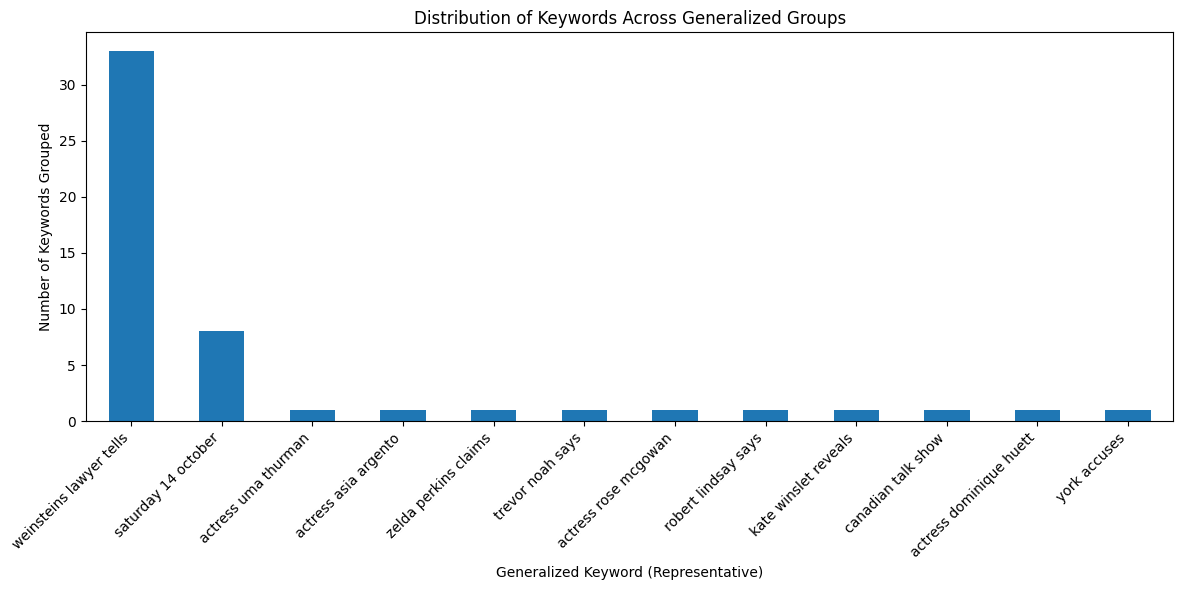

In [ ]:
import matplotlib.pyplot as plt

# Bar chart of cluster sizes
plt.figure(figsize=(12,6))
clusters_df.plot(
    x="Representative",
    y="Count",
    kind="bar",
    legend=False,
    figsize=(12,6)
)
plt.xlabel("Generalized Keyword (Representative)")
plt.ylabel("Number of Keywords Grouped")
plt.title("Distribution of Keywords Across Generalized Groups")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Cluster Visualization

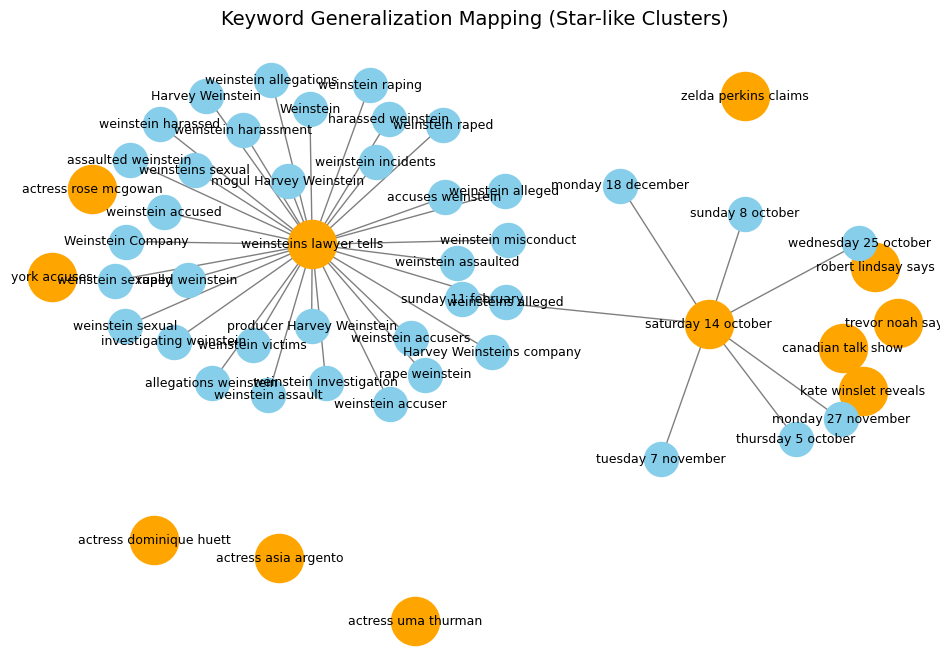

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph
G = nx.Graph()

for _, row in clusters_df.iterrows():
    rep = row["Representative"]
    members = row["Members"].split(", ")

    # Add representative node
    G.add_node(rep, type="rep")

    # Add member nodes + edges to representative
    for m in members:
        if m != rep:  # skip if same
            G.add_node(m, type="member")
            G.add_edge(rep, m)

# Draw graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)  # nice layout

# Separate representative vs members
rep_nodes = [n for n, d in G.nodes(data=True) if d['type']=="rep"]
member_nodes = [n for n, d in G.nodes(data=True) if d['type']=="member"]

# Draw representatives (bigger & different color)
nx.draw_networkx_nodes(G, pos, nodelist=rep_nodes, node_size=1200, node_color="orange")
nx.draw_networkx_nodes(G, pos, nodelist=member_nodes, node_size=600, node_color="skyblue")

# Draw edges + labels
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title("Keyword Generalization Mapping (Star-like Clusters)", fontsize=14)
plt.axis("off")
plt.show()


this code is adding a new column for every keyword column with the genralized word for the keyword

In [ ]:
# # Install dependencies
# !pip install pandas openpyxl

# import pandas as pd
from google.colab import files

# ===== Function to read file based on extension =====
def read_file(file_path):
    if file_path.lower().endswith(".csv"):
        return pd.read_csv(file_path)
    else:
        return pd.read_excel(file_path)


# ===== 1. UPLOAD FILES =====
print("Upload the file with 'keyword' and 'Generalized_Keyword'")
uploaded1 = files.upload()
file1 = list(uploaded1.keys())[0]

print("Upload the file with keyword1, keyword2, keyword3, and sentiment")
uploaded2 = files.upload()
file2 = list(uploaded2.keys())[0]

# ===== 2. READ FILES (supports CSV or Excel) =====
df_mapping = read_file(file1)  # first file
df_data = read_file(file2)     # second file

# Ensure correct column names in mapping file
mapping_col_keyword = None
mapping_col_general = None

for col in df_mapping.columns:
    if "keyword" in col.lower() and "generalized" not in col.lower():
        mapping_col_keyword = col
    elif "generalized" in col.lower():
        mapping_col_general = col

if mapping_col_keyword is None or mapping_col_general is None:
    raise ValueError("Could not detect keyword/generalized keyword columns in mapping file.")

# Create dictionary for mapping
general_map = dict(zip(df_mapping[mapping_col_keyword].astype(str),
                       df_mapping[mapping_col_general].astype(str)))

# ===== 3. Add generalized keyword columns =====
for i in range(1, 4):
    kw_col = f"keyword{i}"
    gen_col = f"generalized_keyword{i}"
    if kw_col in df_data.columns:
        df_data[gen_col] = df_data[kw_col].astype(str).map(general_map).fillna("")


# ===== 4. SAVE NEW FILE =====
output_file = "keywords_with_generalized.xlsx"
df_data.to_excel(output_file, index=False)
# output_file = "keywords_with_generalized.csv"
# df_data.to_csv(output_file, index=False)
files.download(output_file)

print(f"✅ Done! File saved as {output_file}")


Upload the file with 'keyword' and 'Generalized_Keyword'


Saving generalized_targetsHW.xlsx to generalized_targetsHW.xlsx
Upload the file with keyword1, keyword2, keyword3, and sentiment


Saving keyword_relationshipsHW.csv to keyword_relationshipsHW.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done! File saved as keywords_with_generalized.xlsx
